Visualizing mask and image: 02_00_000.png


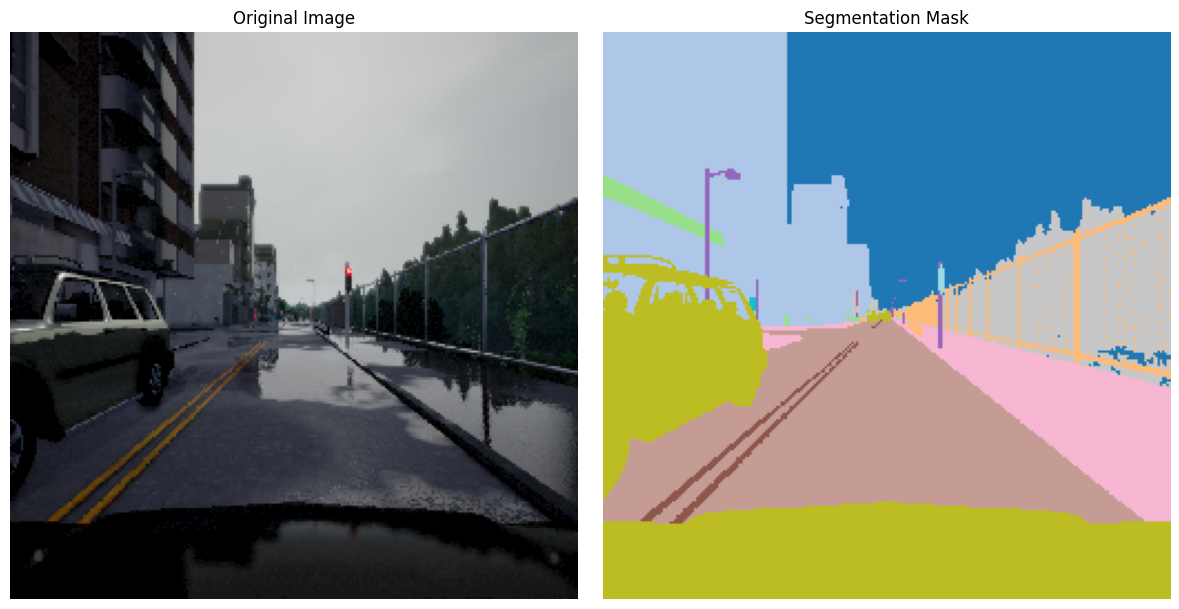

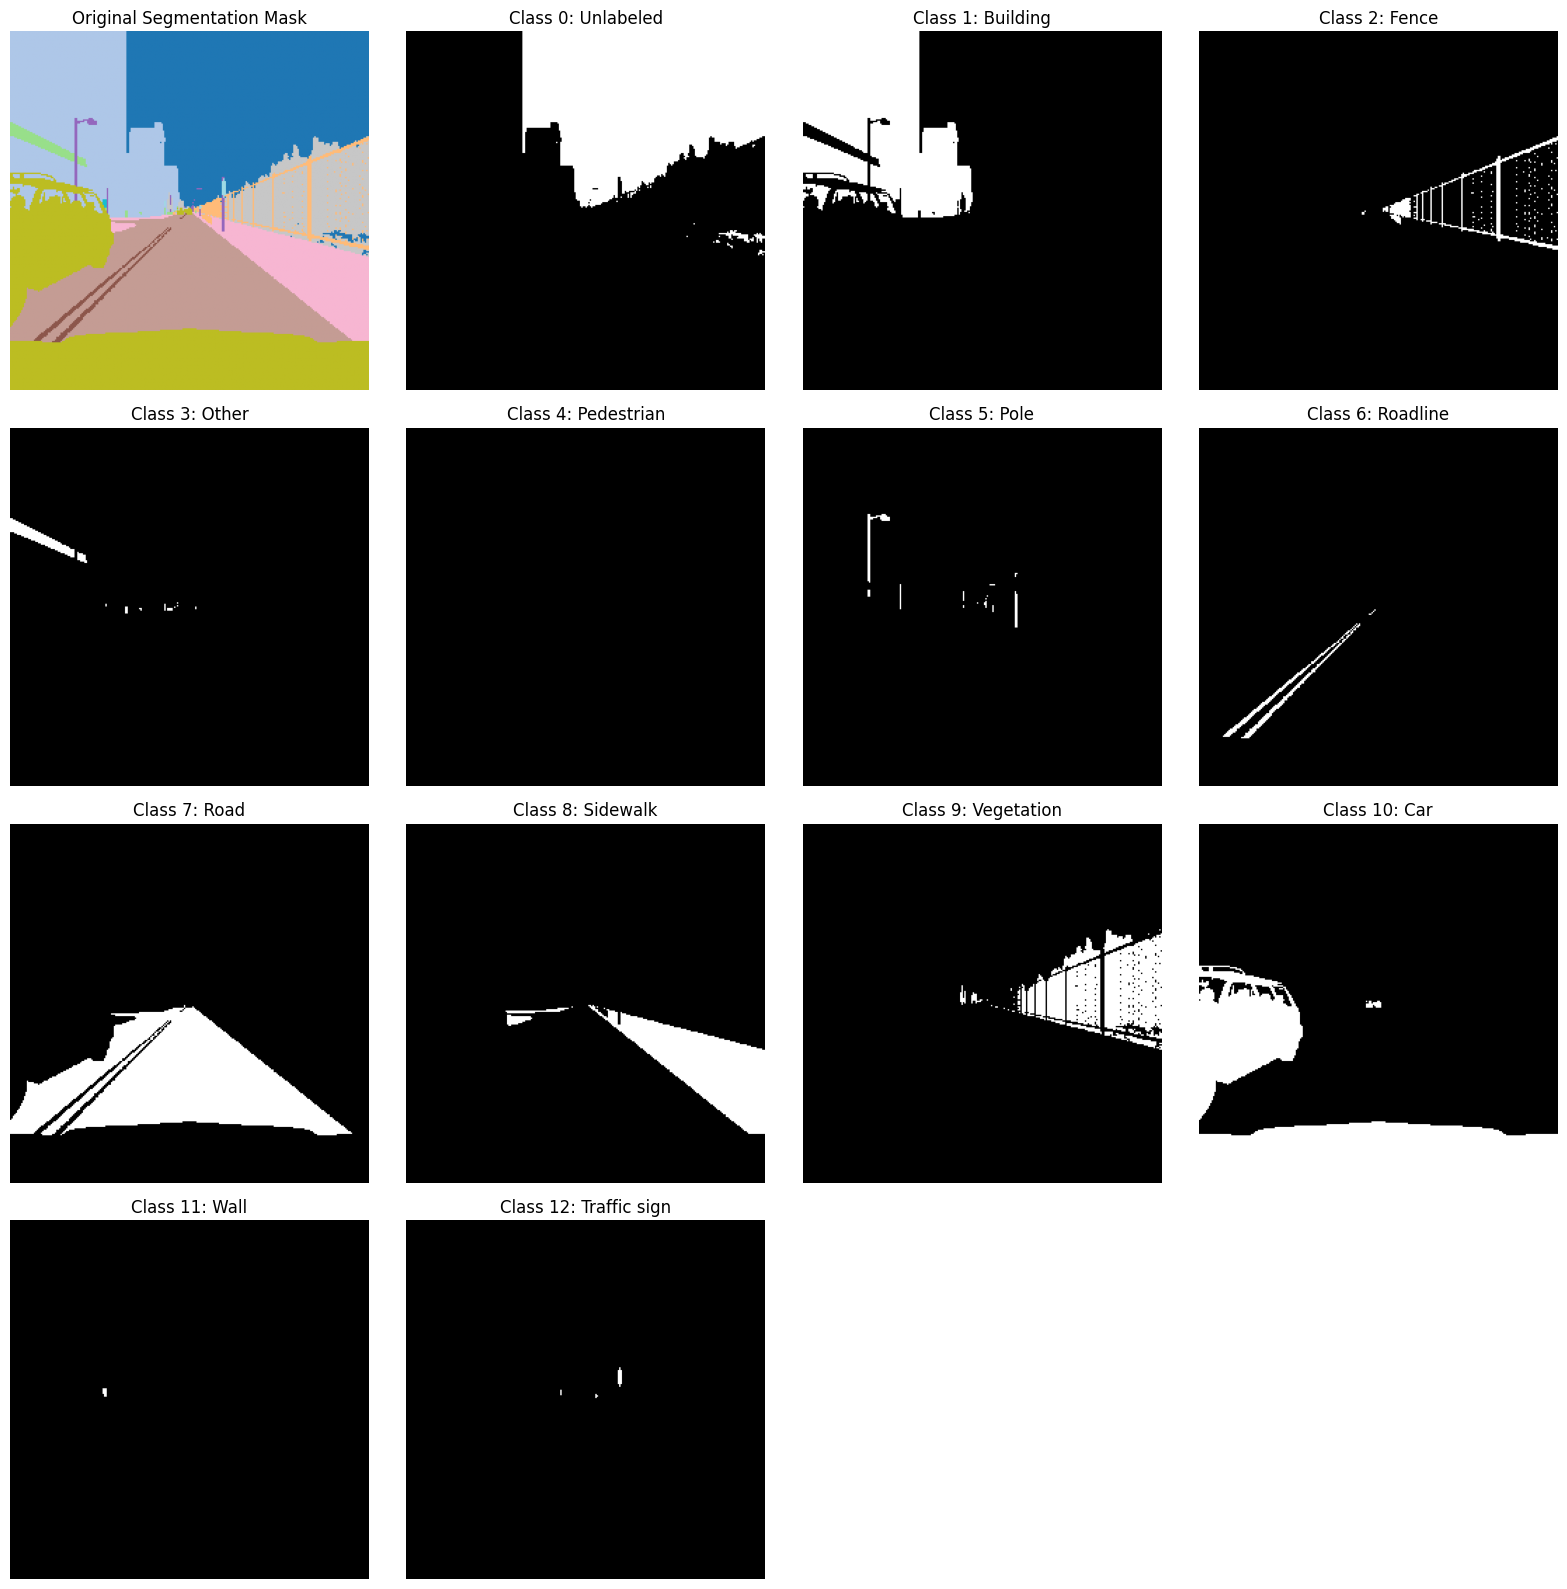

Visualizing mask and image: 02_01_000.png


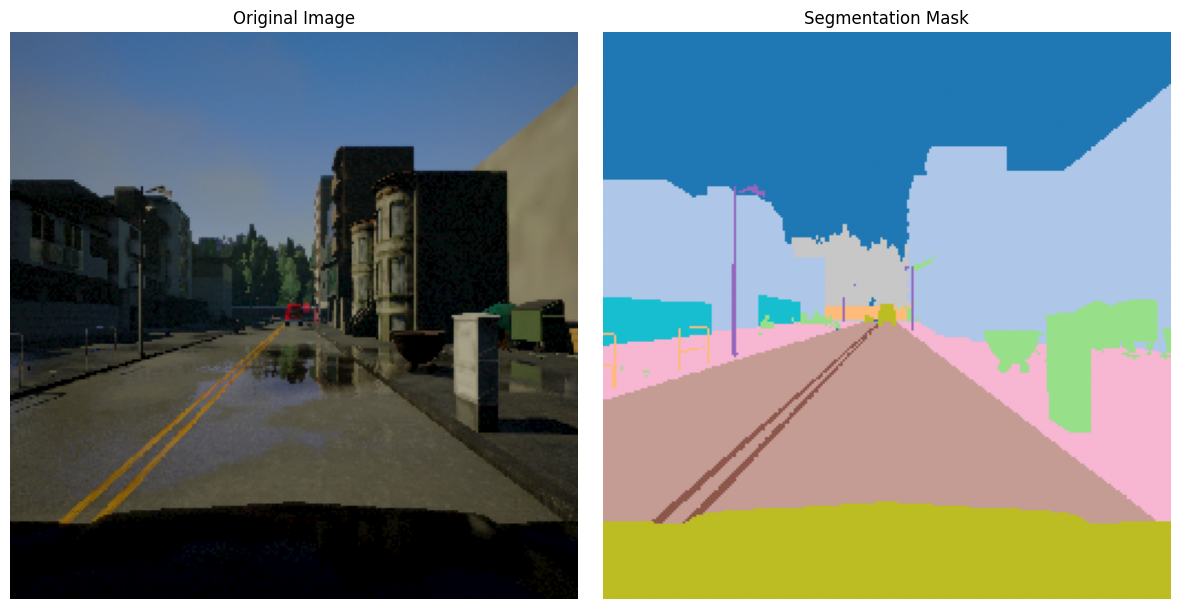

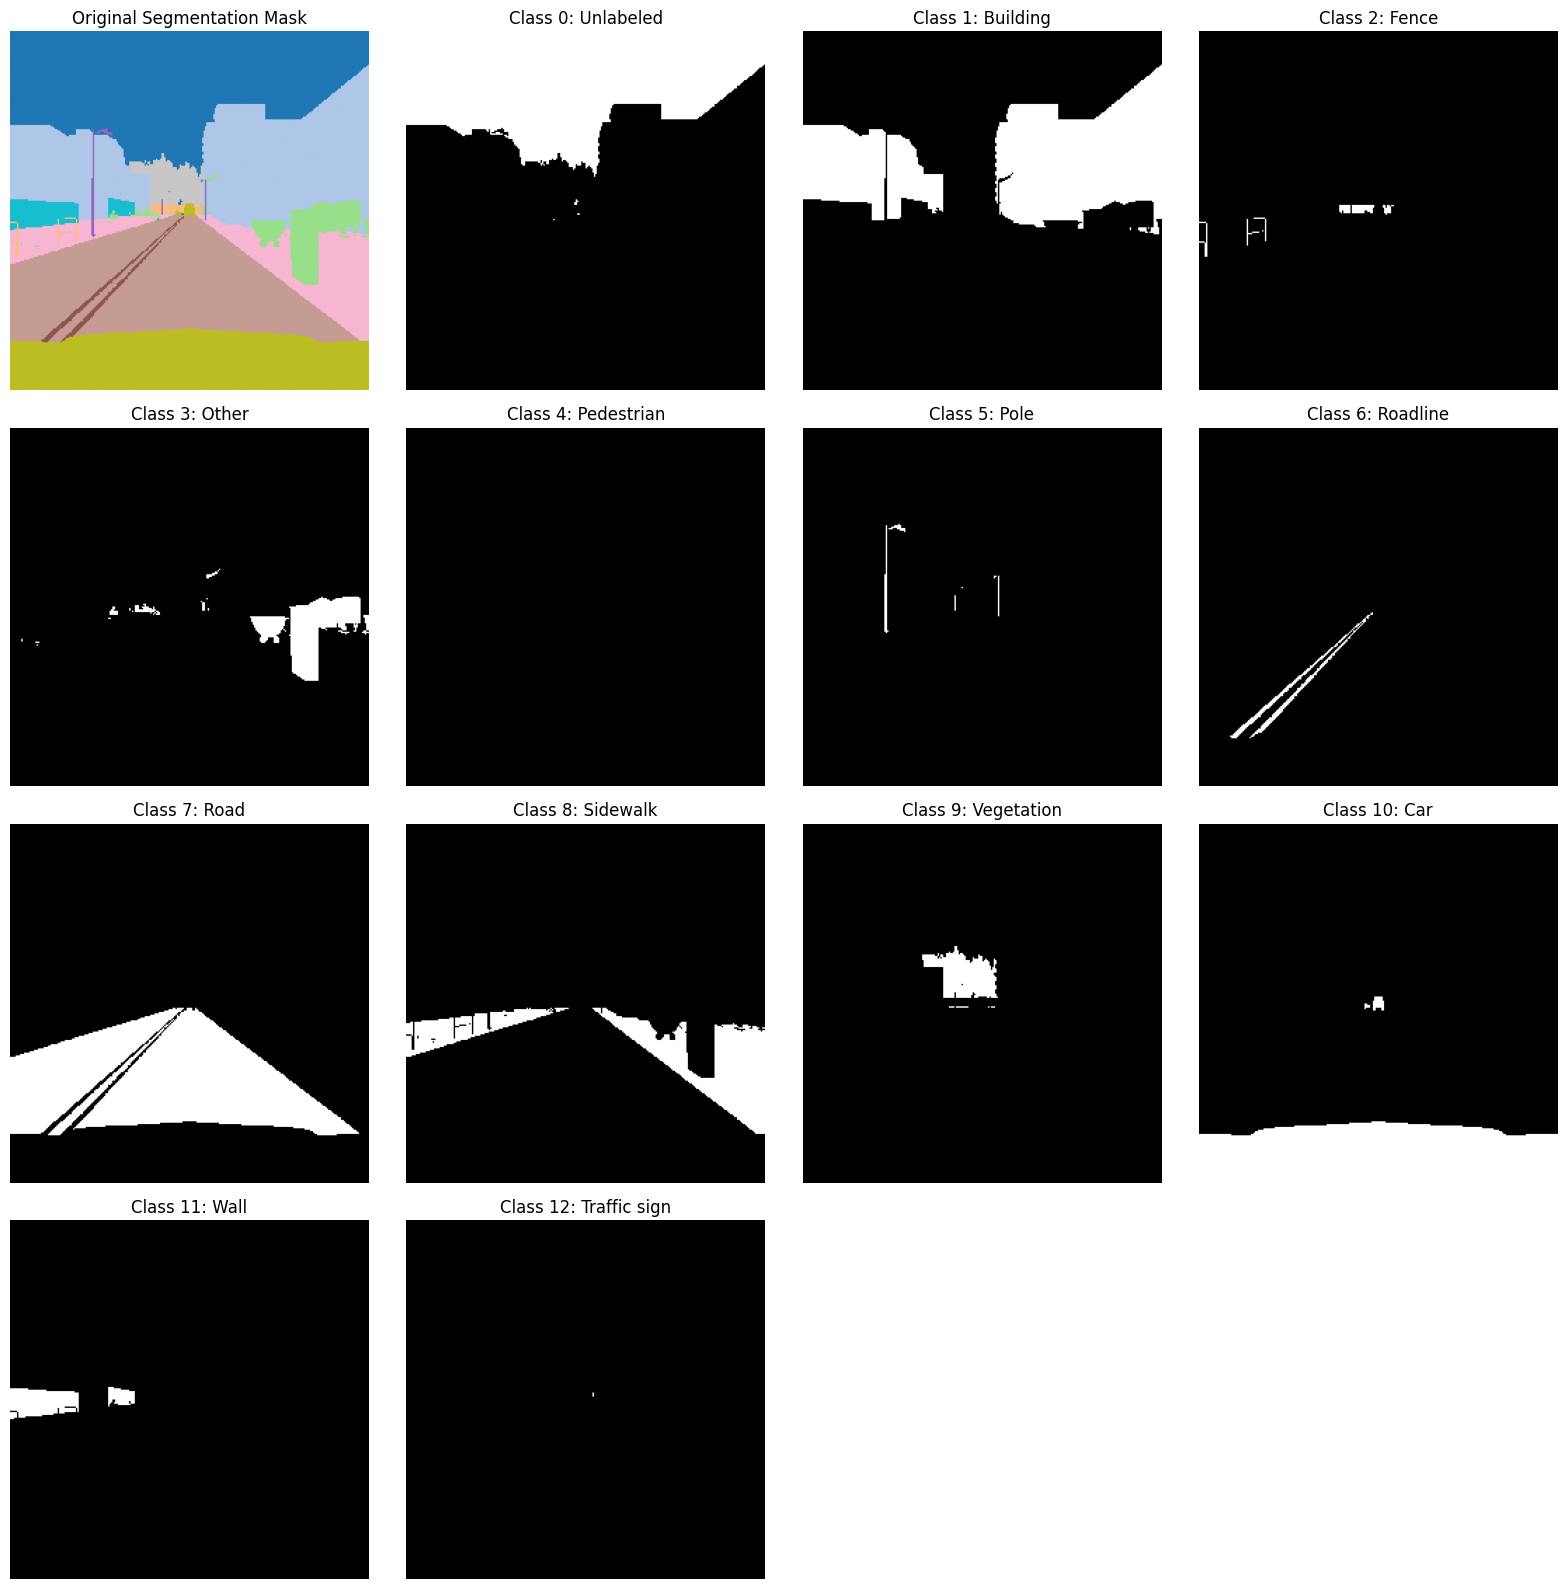

Visualizing mask and image: 02_02_000.png


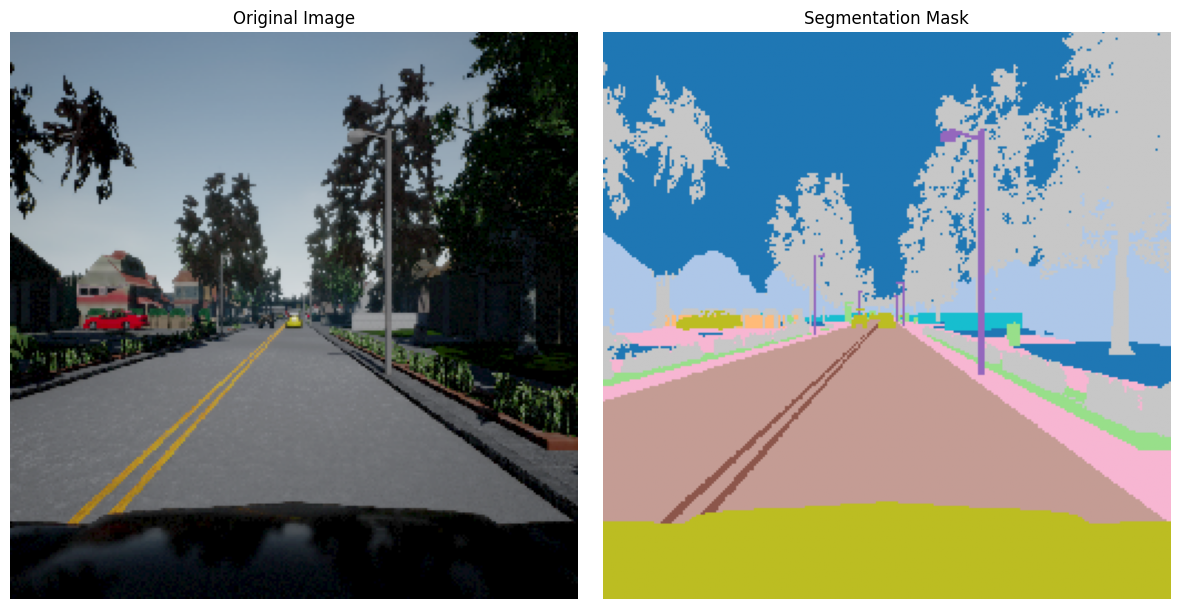

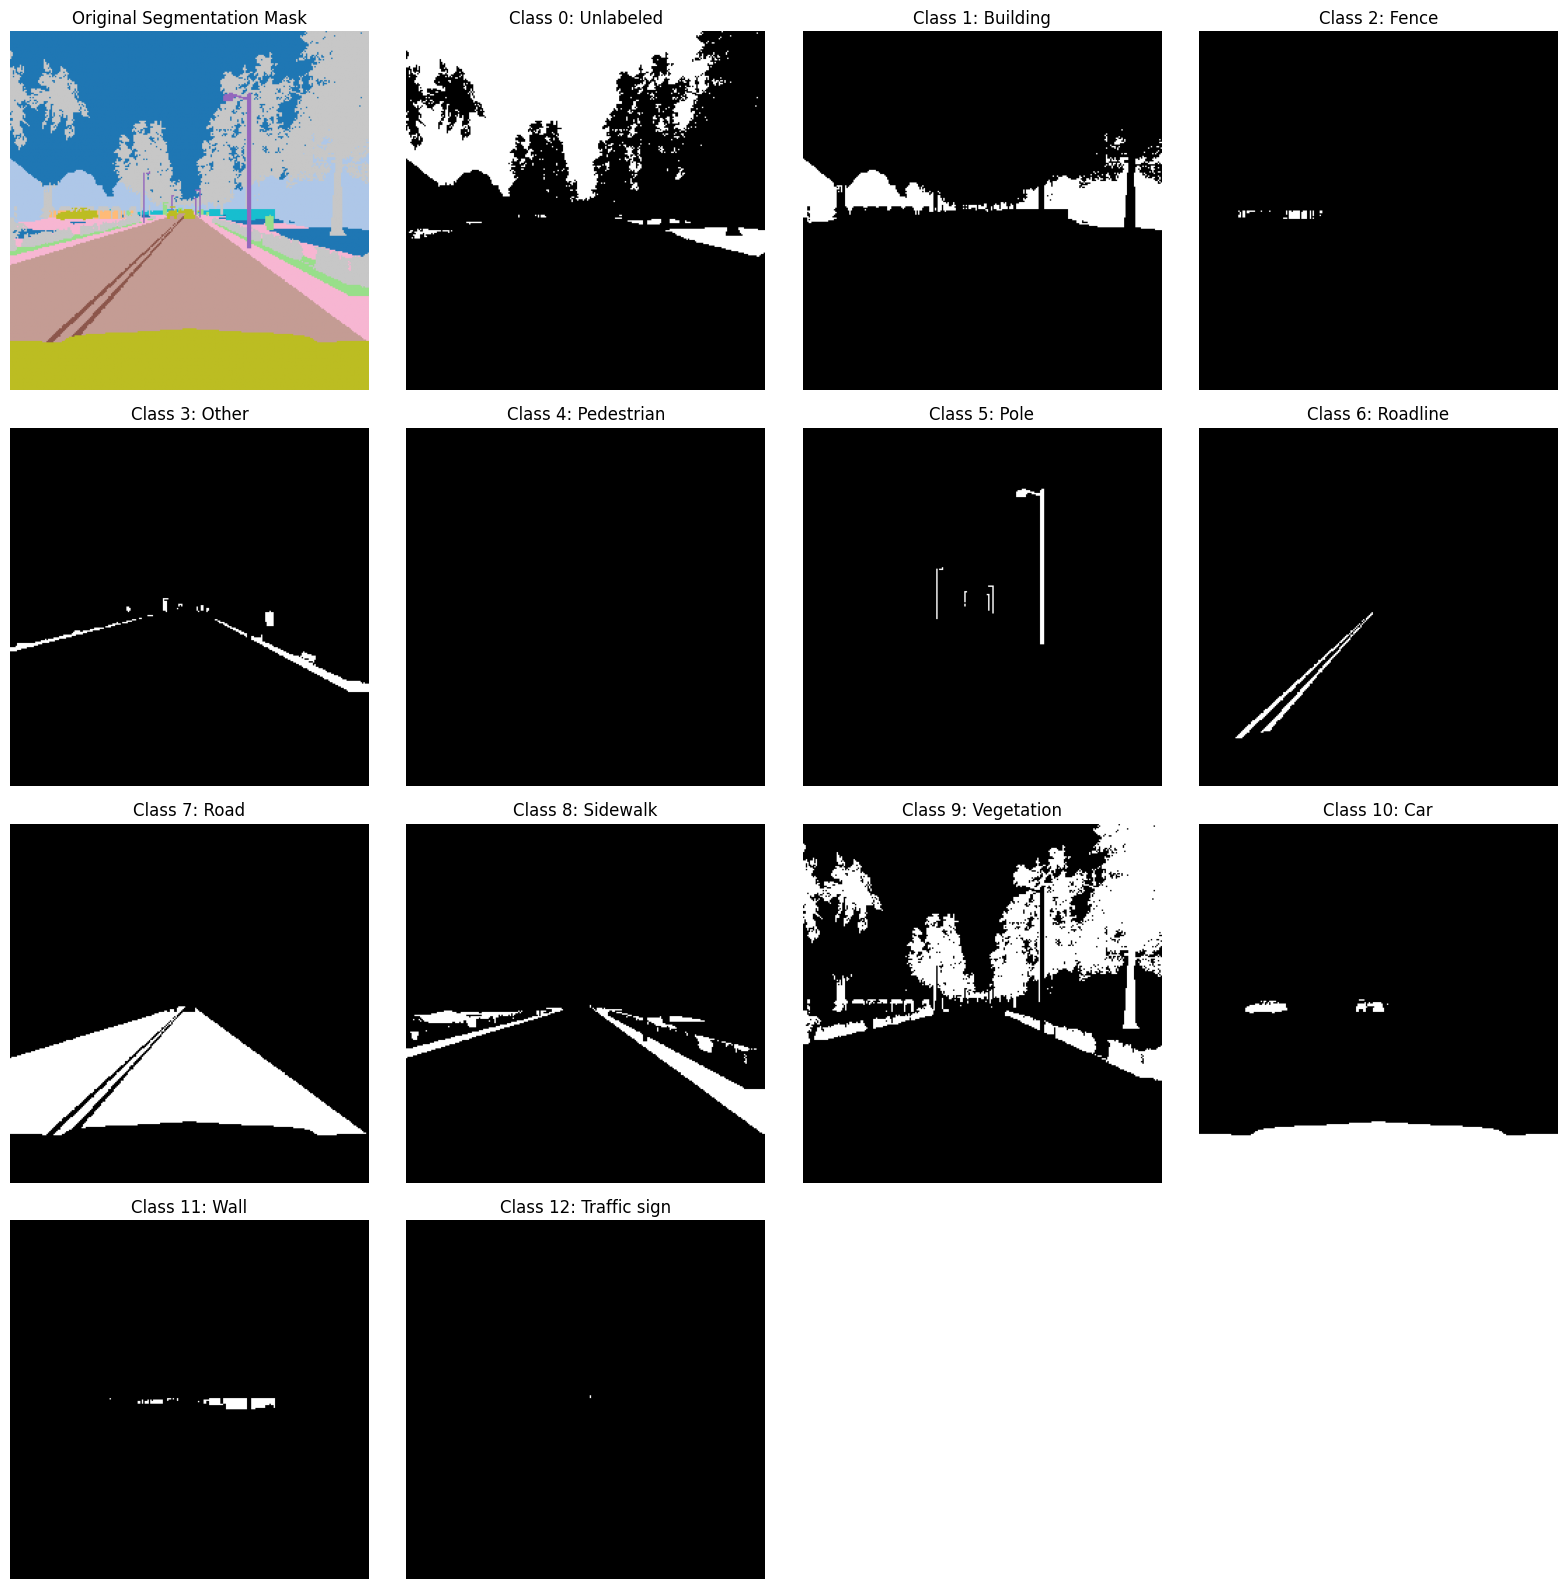

Visualizing mask and image: 03_00_000.png


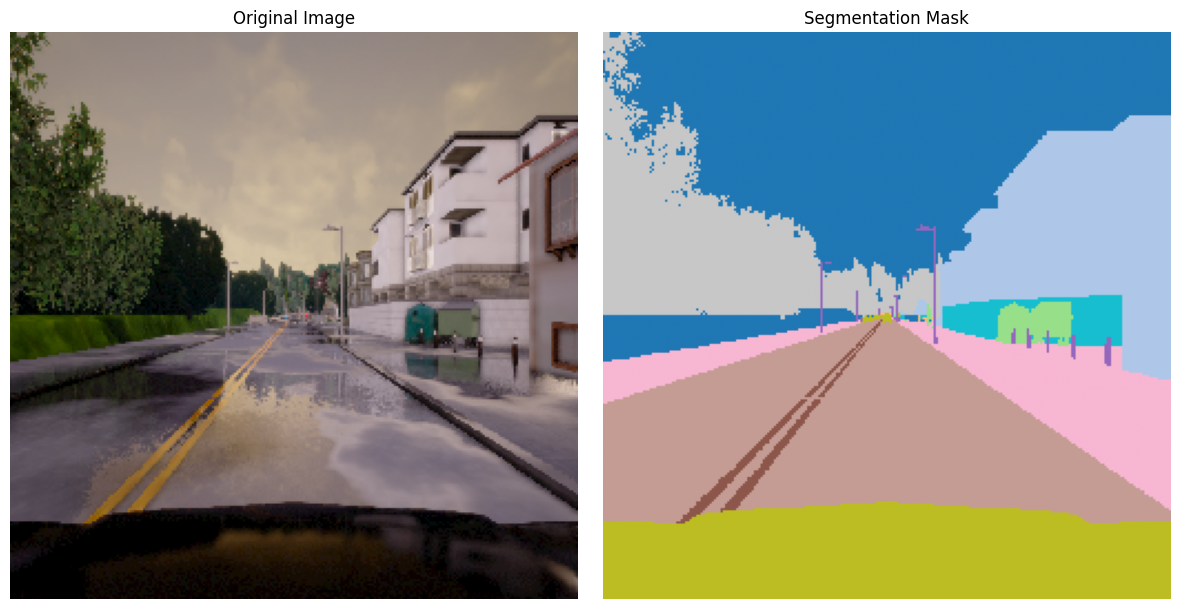

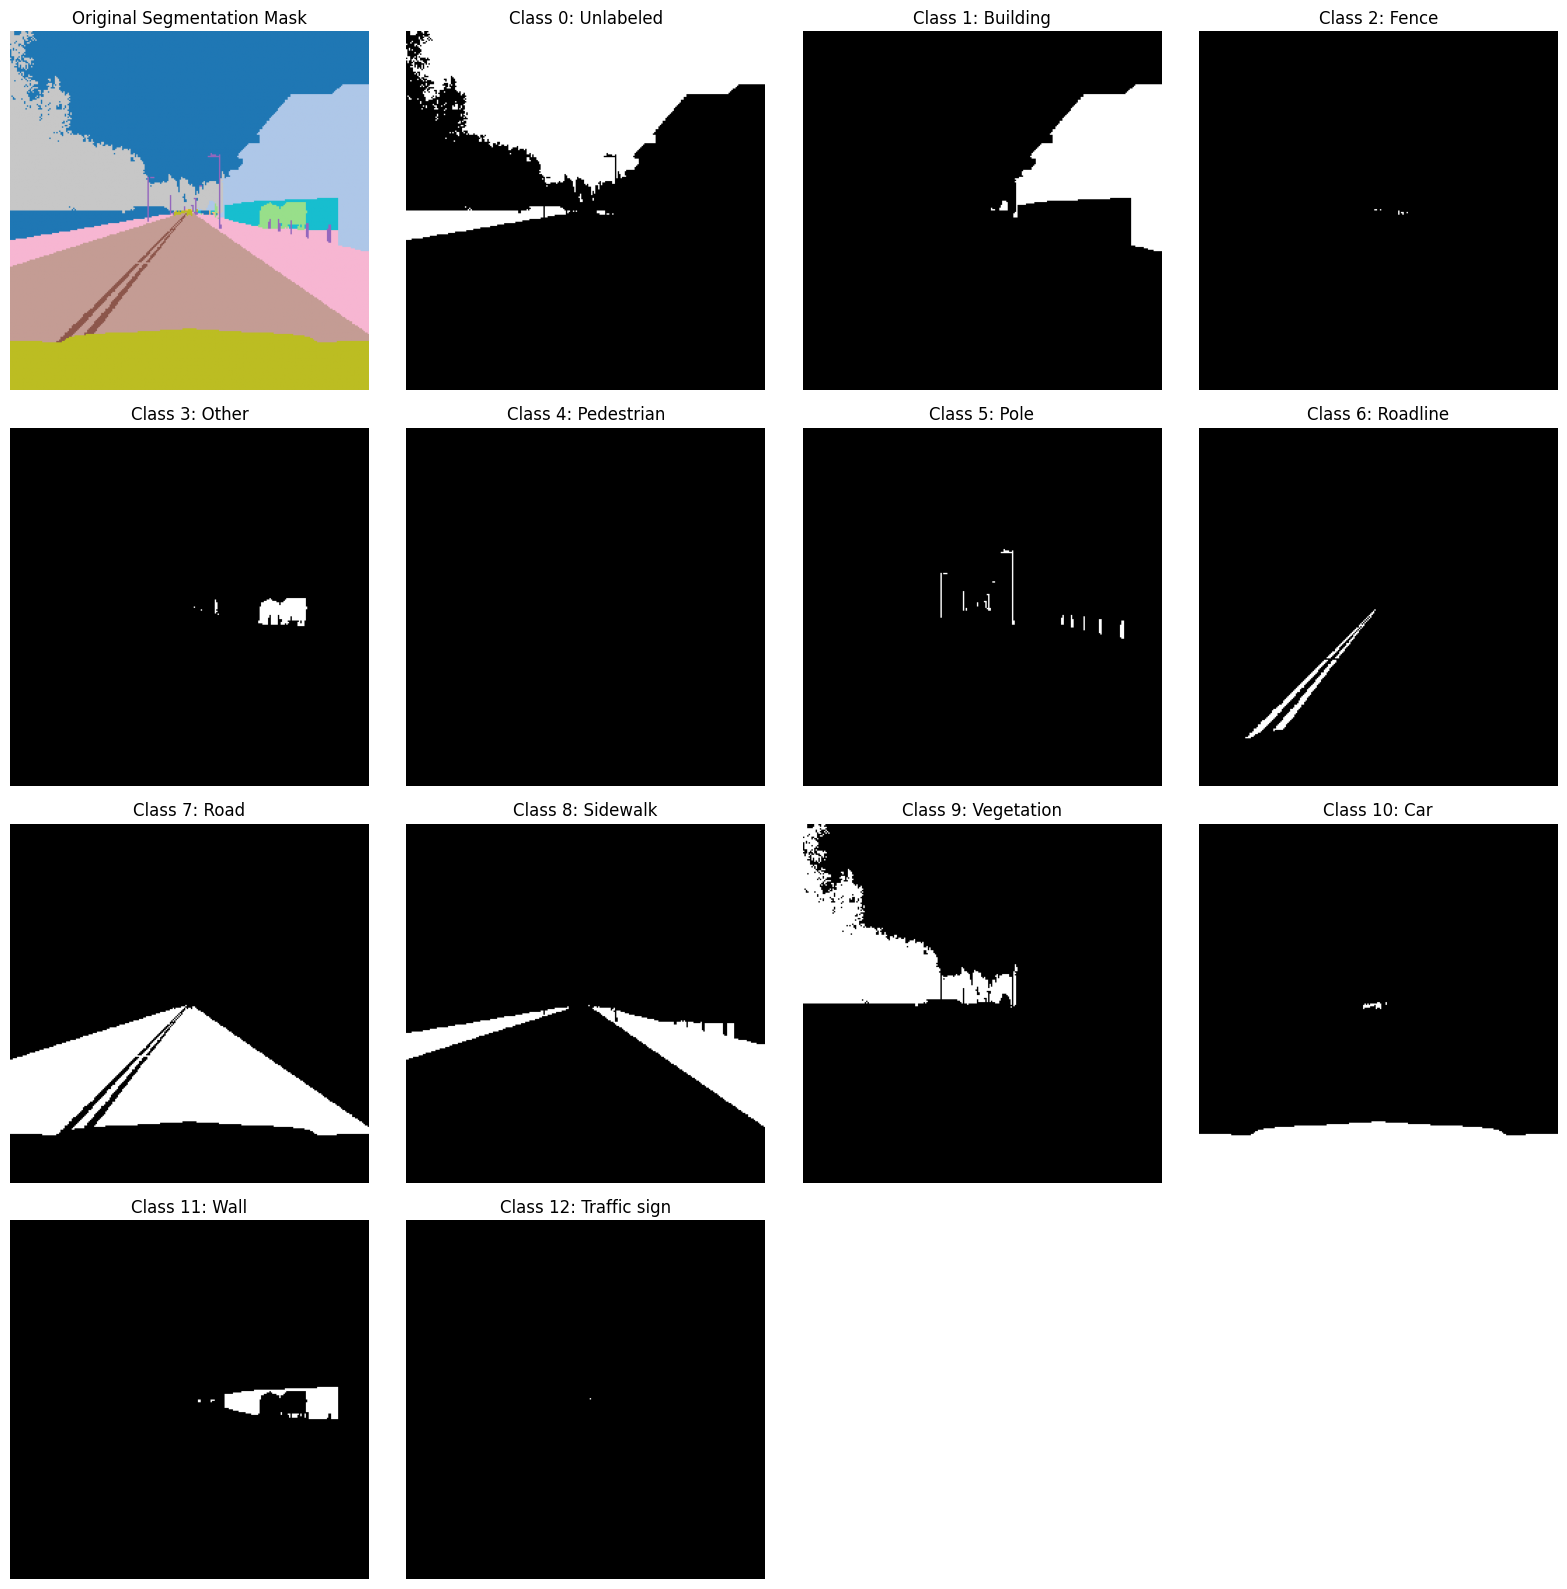

Visualizing mask and image: 03_01_000.png


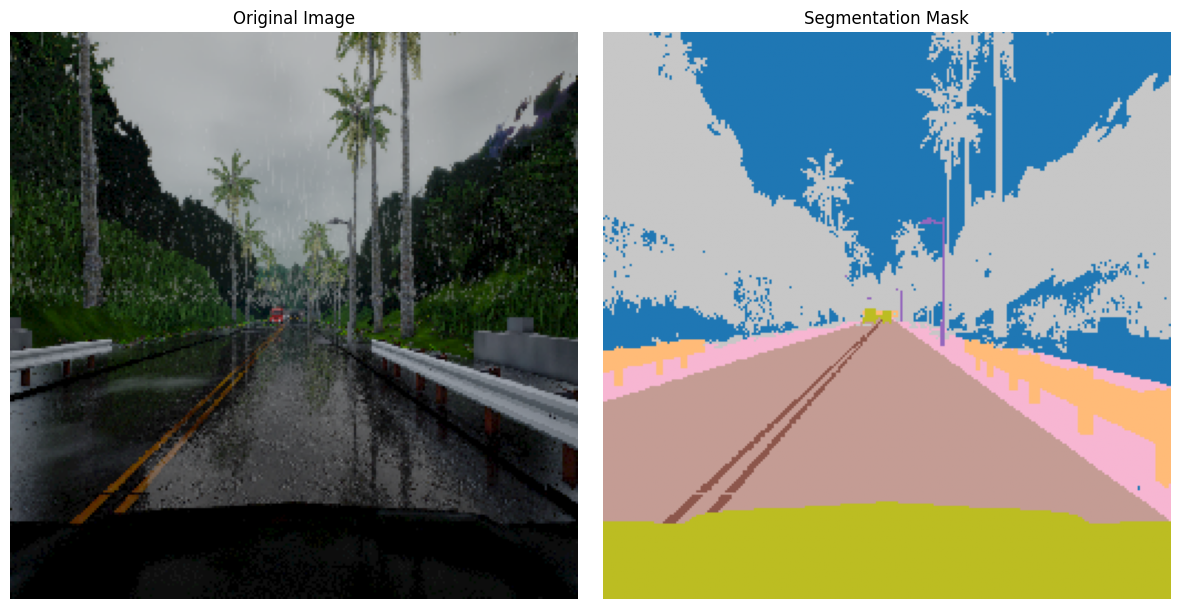

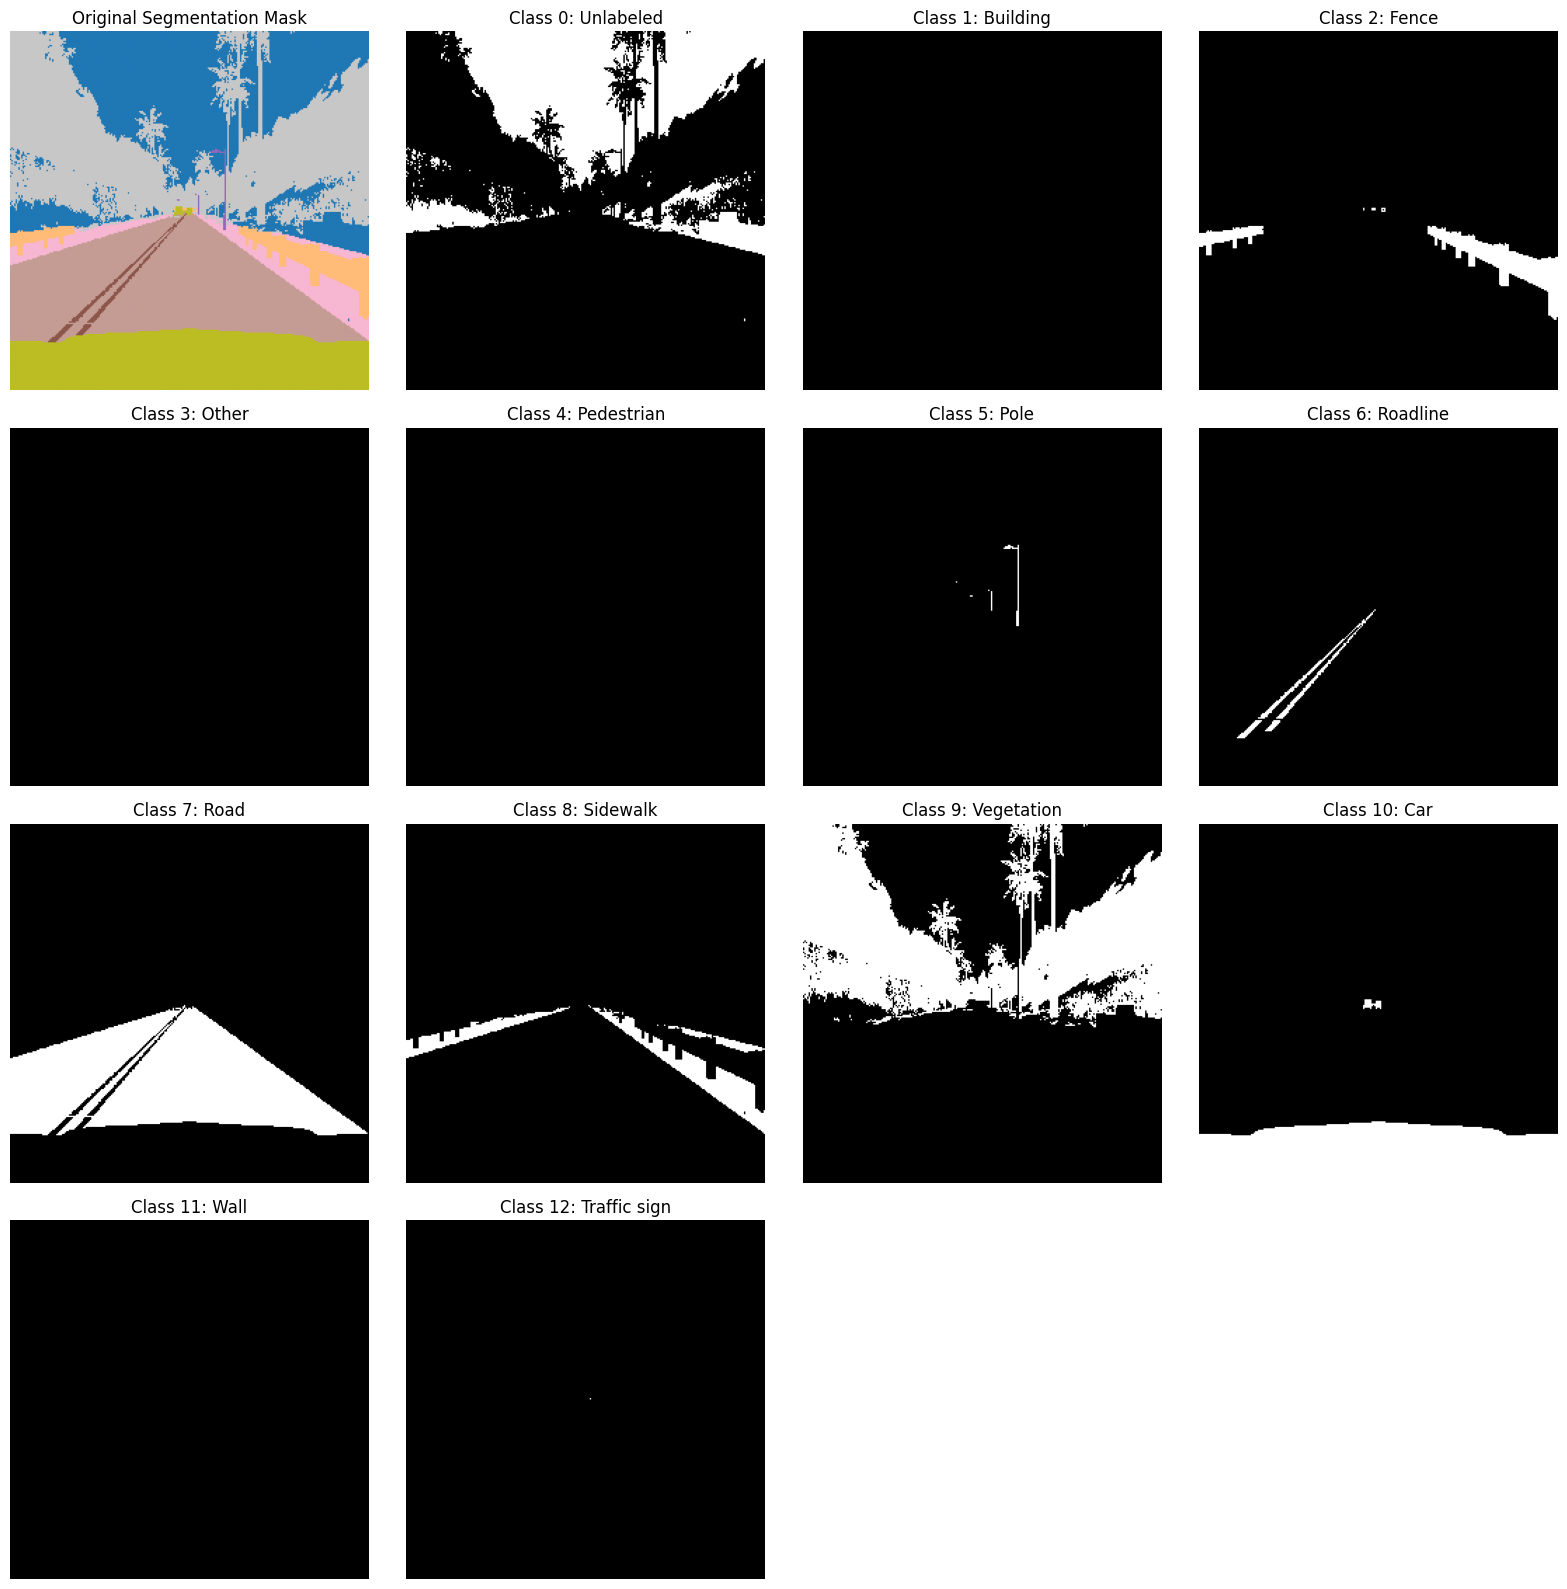

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import torch
from matplotlib.colors import ListedColormap

# Define class names
class_names = [
    "Unlabeled", "Building", "Fence", "Other", "Pedestrian", "Pole",
    "Roadline", "Road", "Sidewalk", "Vegetation", "Car", "Wall", "Traffic sign"
]

def visualize_segmentation_classes(mask_path):
    """
    Function to visualize each class in a segmentation mask.
    
    Args:
        mask_path (str): Path to the segmentation mask image.
    """
    # Read the mask image
    mask = np.array(Image.open(mask_path))
    
    # Extract the first channel if the mask has multiple channels
    if len(mask.shape) > 2:
        class_ids = mask[:, :, 0]
    else:
        class_ids = mask
    
    # Create a figure for visualization
    num_classes = len(class_names)
    rows = 4
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
    axes = axes.flatten()
    
    # Create a colormap for the mask to visualize the original segmentation
    colors = plt.cm.tab20(np.linspace(0, 1, num_classes))
    custom_cmap = ListedColormap(colors)
    
    # Add original mask to the visualization
    colored_mask = custom_cmap(class_ids)
    axes[0].imshow(colored_mask)
    axes[0].set_title("Original Segmentation Mask")
    axes[0].axis('off')
    
    # Visualize each class as a binary mask
    for class_id in range(num_classes):
        # Create binary mask for this class
        binary_mask = (class_ids == class_id).astype(np.uint8) * 255
        
        # Visualize
        ax_idx = class_id + 1
        if ax_idx < len(axes):
            axes[ax_idx].imshow(binary_mask, cmap='gray')
            axes[ax_idx].set_title(f"Class {class_id}: {class_names[class_id]}")
            axes[ax_idx].axis('off')
    
    # Hide empty subplots
    for i in range(num_classes + 1, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

def visualize_image_with_mask(image_path, mask_path):
    """
    Function to visualize an image alongside its segmentation mask.
    
    Args:
        image_path (str): Path to the input image.
        mask_path (str): Path to the segmentation mask image.
    """
    # Read the image and mask
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))
    
    # Extract the first channel if the mask has multiple channels
    if len(mask.shape) > 2:
        class_ids = mask[:, :, 0]
    else:
        class_ids = mask
    
    # Create a figure for visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Create a colormap for the mask
    colors = plt.cm.tab20(np.linspace(0, 1, len(class_names)))
    custom_cmap = ListedColormap(colors)
    
    # Display colored mask
    colored_mask = custom_cmap(class_ids)
    axes[1].imshow(colored_mask)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Use a sample from the dataset
dataset_path = "/kaggle/input/q2-unet/dataset_256"  
# dataset_path = "/kaggle/input/q1-data/dataset_224"
train_images_path = os.path.join(dataset_path, "train", "images")
train_labels_path = os.path.join(dataset_path, "train", "labels")

# List all files in the train labels directory
mask_files = sorted(os.listdir(train_labels_path))
if not mask_files:
    print("No mask files found in the directory.")
else:
    # Choose a sample mask file (using the first one for consistency)
    for i in range(5):
        sample_mask_file = mask_files[i*100]
        sample_mask_path = os.path.join(train_labels_path, sample_mask_file)
        
        # Find the corresponding image file
        sample_image_path = os.path.join(train_images_path, sample_mask_file)
        
        print(f"Visualizing mask and image: {sample_mask_file}")
        
        # Display the image alongside its mask
        visualize_image_with_mask(sample_image_path, sample_mask_path)
        
        # Visualize each class in the segmentation mask
        visualize_segmentation_classes(sample_mask_path)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import random

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define class names
class_names = [
    "Unlabeled", "Building", "Fence", "Other", "Pedestrian", "Pole",
    "Roadline", "Road", "Sidewalk", "Vegetation", "Car", "Wall", "Traffic sign"
]
num_classes = len(class_names)

# Define paths for Kaggle
dataset_path = "/kaggle/input/q2-unet/dataset_256"
train_images_path = os.path.join(dataset_path, "train", "images")
train_labels_path = os.path.join(dataset_path, "train", "labels")
test_images_path = os.path.join(dataset_path, "test", "images")
test_labels_path = os.path.join(dataset_path, "test", "labels")

# Define U-Net model architecture
class DoubleConv(nn.Module):
    """(Conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        
        # Use transposed convolution for upsampling as specified
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Ensure x1 has the same size as x2 (sometimes they can differ by 1 pixel)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, 
                         diffY // 2, diffY - diffY // 2])
        
        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # Encoder path (contracting)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        
        # Bottleneck
        self.down4 = Down(512, 1024)
        
        # Decoder path (expansive)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        
        # Final convolution
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        # Bottleneck
        x5 = self.down4(x4)
        
        # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # Final layer
        logits = self.outc(x)
        return logits

# Dataset class
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted(os.listdir(images_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name)
        
        # Load image and mask
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))
        
        # Extract class IDs from mask
        if len(mask.shape) > 2:
            mask = mask[:, :, 0]  # Take first channel if multiple channels
        
        # Convert to tensors and normalize image
        if self.transform:
            # Apply transformations if provided
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        else:
            # Basic transformation
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.0
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask).long()  # Ensure mask is Long type
        
        return image, mask

# Calculate Mean IoU
def calculate_miou(pred, target, num_classes):
    iou_list = []
    pred = pred.argmax(dim=1).view(-1)
    target = target.view(-1)
    
    # Calculate IoU for each class
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            iou = 1.0  # If there's no ground truth and no prediction, consider it perfect
        else:
            iou = intersection / union
        
        iou_list.append(iou)
    
    return np.mean(iou_list)

# Function to visualize predictions
# Update the visualization function to properly handle normalized images
def visualize_prediction(image, mask, pred, idx):
    """
    Visualize the image, ground truth mask and prediction side by side
    """
    # Create a colormap for the segmentation masks
    colors = plt.cm.tab20(np.linspace(0, 1, num_classes))
    custom_cmap = ListedColormap(colors)
    
    # Convert tensors to numpy arrays
    if torch.is_tensor(image):
        image = image.cpu().numpy().transpose(1, 2, 0)  # Convert from CxHxW to HxWxC
        
    if torch.is_tensor(mask):
        mask = mask.cpu().numpy()
        
    if torch.is_tensor(pred):
        pred = pred.argmax(dim=0).cpu().numpy()
    
    # Denormalize image if it was normalized using ImageNet mean/std
    if image.min() < 0 or image.max() <= 1.0:
        # Check if image is normalized with ImageNet stats
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        # Denormalize
        image = image * std + mean
        image = np.clip(image, 0, 1)
        image = (image * 255).astype(np.uint8)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original image
    axes[0].imshow(image)
    axes[0].set_title("Input Image")
    axes[0].axis('off')
    
    # Plot ground truth mask
    axes[1].imshow(custom_cmap(mask))
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')
    
    # Plot prediction
    axes[2].imshow(custom_cmap(pred))
    axes[2].set_title("Prediction")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"/kaggle/working/prediction_{idx}.png")
    plt.close()

# Train function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda'):
    model.to(device)
    best_miou = 0.0
    
    # Track metrics
    train_losses = []
    val_losses = []
    train_mious = []
    val_mious = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_miou = 0.0
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        progress_bar = tqdm(train_loader, desc="Training")
        
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Ensure masks are in long format for CrossEntropyLoss
            masks = masks.long()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item() * images.size(0)
            train_miou += calculate_miou(outputs, masks, num_classes) * images.size(0)
            
            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())
        
        train_loss = train_loss / len(train_loader.dataset)
        train_miou = train_miou / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_mious.append(train_miou)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_miou = 0.0
        
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc="Validation")
            
            for images, masks in progress_bar:
                images = images.to(device)
                masks = masks.to(device)
                
                # Ensure masks are in long format for CrossEntropyLoss
                masks = masks.long()
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item() * images.size(0)
                val_miou += calculate_miou(outputs, masks, num_classes) * images.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_miou = val_miou / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_mious.append(val_miou)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train mIoU: {train_miou:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val mIoU: {val_miou:.4f}")
        
        # Save model if validation mIoU improved
        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(model.state_dict(), 'best_unet_model.pth')  # Save to Kaggle working directory
            print(f"Model saved with validation mIoU: {val_miou:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_mious, label='Train mIoU')
    plt.plot(val_mious, label='Val mIoU')
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()
    plt.title('mIoU Curves')
    
    plt.tight_layout()
    plt.savefig('training_curves.png')  # Save to Kaggle working directory
    plt.show()
    
    return train_losses, val_losses, train_mious, val_mious

# Test model and visualize predictions
def test_model(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    
    test_miou = 0.0
    samples_to_visualize = 5
    visualized = 0
    
    with torch.no_grad():
        for idx, (images, masks) in enumerate(tqdm(test_loader, desc="Testing")):
            images = images.to(device)
            masks = masks.to(device)
            
            # Ensure masks are in long format for CrossEntropyLoss
            masks = masks.long()
            
            outputs = model(images)
            
            # Calculate mIoU
            batch_miou = calculate_miou(outputs, masks, num_classes)
            test_miou += batch_miou * images.size(0)
            # print(samples_to_visualize)
            # print(visualized)
            # Visualize a few predictions
            if visualized < samples_to_visualize:
                # print("I am here")
                for i in range(min(images.size(0), samples_to_visualize - visualized)):
                    # print("I am here inside inner loop")

                    visualize_prediction(
                        images[i].cpu(), 
                        masks[i].cpu(), 
                        outputs[i].cpu(), 
                        visualized
                    )
                    visualized += 1
                    if visualized >= samples_to_visualize:
                        break
    
    test_miou = test_miou / len(test_loader.dataset)
    print(f"Test mIoU: {test_miou:.4f}")
    
    return test_miou


Train images directory exists: True
Train labels directory exists: True
Test images directory exists: True
Test labels directory exists: True
Using device: cuda


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using albumentations library for transformations
Training dataset size: 1600
Validation dataset size: 400
Test dataset size: 500
Number of trainable parameters: 31044301
Starting model training...
Epoch 1/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.06it/s]


Epoch 1/50, Train Loss: 0.6149, Train mIoU: 0.3684, Val Loss: 0.4006, Val mIoU: 0.4544
Model saved with validation mIoU: 0.4544
Epoch 2/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.28it/s]


Epoch 2/50, Train Loss: 0.2850, Train mIoU: 0.4855, Val Loss: 0.3969, Val mIoU: 0.4756
Model saved with validation mIoU: 0.4756
Epoch 3/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.23it/s]


Epoch 3/50, Train Loss: 0.2205, Train mIoU: 0.5364, Val Loss: 0.2524, Val mIoU: 0.5416
Model saved with validation mIoU: 0.5416
Epoch 4/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.30it/s]


Epoch 4/50, Train Loss: 0.1834, Train mIoU: 0.5755, Val Loss: 0.1709, Val mIoU: 0.5974
Model saved with validation mIoU: 0.5974
Epoch 5/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.31it/s]


Epoch 5/50, Train Loss: 0.1586, Train mIoU: 0.6038, Val Loss: 0.2514, Val mIoU: 0.5668
Epoch 6/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.20it/s]


Epoch 6/50, Train Loss: 0.1451, Train mIoU: 0.6241, Val Loss: 0.1370, Val mIoU: 0.6484
Model saved with validation mIoU: 0.6484
Epoch 7/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.30it/s]


Epoch 7/50, Train Loss: 0.1257, Train mIoU: 0.6517, Val Loss: 0.1306, Val mIoU: 0.6582
Model saved with validation mIoU: 0.6582
Epoch 8/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.29it/s]


Epoch 8/50, Train Loss: 0.1141, Train mIoU: 0.6727, Val Loss: 0.1355, Val mIoU: 0.6603
Model saved with validation mIoU: 0.6603
Epoch 9/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


Epoch 9/50, Train Loss: 0.1039, Train mIoU: 0.6901, Val Loss: 0.1059, Val mIoU: 0.6947
Model saved with validation mIoU: 0.6947
Epoch 10/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.30it/s]


Epoch 10/50, Train Loss: 0.0946, Train mIoU: 0.7057, Val Loss: 0.1042, Val mIoU: 0.7083
Model saved with validation mIoU: 0.7083
Epoch 11/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.30it/s]


Epoch 11/50, Train Loss: 0.0908, Train mIoU: 0.7165, Val Loss: 0.0919, Val mIoU: 0.7339
Model saved with validation mIoU: 0.7339
Epoch 12/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


Epoch 12/50, Train Loss: 0.0955, Train mIoU: 0.7113, Val Loss: 0.1042, Val mIoU: 0.7041
Epoch 13/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.30it/s]


Epoch 13/50, Train Loss: 0.0776, Train mIoU: 0.7424, Val Loss: 0.0825, Val mIoU: 0.7511
Model saved with validation mIoU: 0.7511
Epoch 14/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.27it/s]


Epoch 14/50, Train Loss: 0.0715, Train mIoU: 0.7564, Val Loss: 0.0807, Val mIoU: 0.7547
Model saved with validation mIoU: 0.7547
Epoch 15/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


Epoch 15/50, Train Loss: 0.0757, Train mIoU: 0.7478, Val Loss: 0.0883, Val mIoU: 0.7533
Epoch 16/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.27it/s]


Epoch 16/50, Train Loss: 0.0666, Train mIoU: 0.7690, Val Loss: 0.0672, Val mIoU: 0.7795
Model saved with validation mIoU: 0.7795
Epoch 17/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.33it/s]


Epoch 17/50, Train Loss: 0.0602, Train mIoU: 0.7788, Val Loss: 0.0881, Val mIoU: 0.7471
Epoch 18/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.29it/s]


Epoch 18/50, Train Loss: 0.1277, Train mIoU: 0.6950, Val Loss: 0.2646, Val mIoU: 0.5711
Epoch 19/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.25it/s]


Epoch 19/50, Train Loss: 0.0991, Train mIoU: 0.7133, Val Loss: 0.0788, Val mIoU: 0.7569
Epoch 20/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


Epoch 20/50, Train Loss: 0.0656, Train mIoU: 0.7694, Val Loss: 0.0712, Val mIoU: 0.7804
Model saved with validation mIoU: 0.7804
Epoch 21/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.31it/s]


Epoch 21/50, Train Loss: 0.0579, Train mIoU: 0.7877, Val Loss: 0.0637, Val mIoU: 0.7909
Model saved with validation mIoU: 0.7909
Epoch 22/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.21it/s]


Epoch 22/50, Train Loss: 0.0553, Train mIoU: 0.7940, Val Loss: 0.0616, Val mIoU: 0.7912
Model saved with validation mIoU: 0.7912
Epoch 23/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.28it/s]


Epoch 23/50, Train Loss: 0.0507, Train mIoU: 0.8067, Val Loss: 0.0597, Val mIoU: 0.7991
Model saved with validation mIoU: 0.7991
Epoch 24/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.30it/s]


Epoch 24/50, Train Loss: 0.0473, Train mIoU: 0.8152, Val Loss: 0.0567, Val mIoU: 0.8051
Model saved with validation mIoU: 0.8051
Epoch 25/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


Epoch 25/50, Train Loss: 0.0454, Train mIoU: 0.8184, Val Loss: 0.0510, Val mIoU: 0.8202
Model saved with validation mIoU: 0.8202
Epoch 26/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.33it/s]


Epoch 26/50, Train Loss: 0.0450, Train mIoU: 0.8214, Val Loss: 0.0538, Val mIoU: 0.8205
Model saved with validation mIoU: 0.8205
Epoch 27/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.27it/s]


Epoch 27/50, Train Loss: 0.0430, Train mIoU: 0.8304, Val Loss: 0.0545, Val mIoU: 0.8142
Epoch 28/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


Epoch 28/50, Train Loss: 0.0465, Train mIoU: 0.8172, Val Loss: 0.0537, Val mIoU: 0.8205
Model saved with validation mIoU: 0.8205
Epoch 29/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.28it/s]


Epoch 29/50, Train Loss: 0.0409, Train mIoU: 0.8287, Val Loss: 0.0553, Val mIoU: 0.8187
Epoch 30/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.25it/s]


Epoch 30/50, Train Loss: 0.0511, Train mIoU: 0.8112, Val Loss: 0.1134, Val mIoU: 0.7364
Epoch 31/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.33it/s]


Epoch 31/50, Train Loss: 0.0473, Train mIoU: 0.8166, Val Loss: 0.0475, Val mIoU: 0.8347
Model saved with validation mIoU: 0.8347
Epoch 32/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.31it/s]


Epoch 32/50, Train Loss: 0.0365, Train mIoU: 0.8431, Val Loss: 0.0465, Val mIoU: 0.8313
Epoch 33/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


Epoch 33/50, Train Loss: 0.0358, Train mIoU: 0.8474, Val Loss: 0.0454, Val mIoU: 0.8396
Model saved with validation mIoU: 0.8396
Epoch 34/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


Epoch 34/50, Train Loss: 0.0344, Train mIoU: 0.8514, Val Loss: 0.0459, Val mIoU: 0.8374
Epoch 35/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.27it/s]


Epoch 35/50, Train Loss: 0.0510, Train mIoU: 0.8180, Val Loss: 0.5061, Val mIoU: 0.5272
Epoch 36/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


Epoch 36/50, Train Loss: 0.0610, Train mIoU: 0.7925, Val Loss: 0.0487, Val mIoU: 0.8289
Epoch 37/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.27it/s]


Epoch 37/50, Train Loss: 0.0358, Train mIoU: 0.8466, Val Loss: 0.0492, Val mIoU: 0.8269
Epoch 38/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.26it/s]


Epoch 38/50, Train Loss: 0.0333, Train mIoU: 0.8554, Val Loss: 0.0424, Val mIoU: 0.8455
Model saved with validation mIoU: 0.8455
Epoch 39/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.28it/s]


Epoch 39/50, Train Loss: 0.0313, Train mIoU: 0.8578, Val Loss: 0.0412, Val mIoU: 0.8498
Model saved with validation mIoU: 0.8498
Epoch 40/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.28it/s]


Epoch 40/50, Train Loss: 0.0305, Train mIoU: 0.8597, Val Loss: 0.0445, Val mIoU: 0.8452
Epoch 41/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.25it/s]


Epoch 41/50, Train Loss: 0.0304, Train mIoU: 0.8593, Val Loss: 0.0413, Val mIoU: 0.8485
Epoch 42/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.25it/s]


Epoch 42/50, Train Loss: 0.0299, Train mIoU: 0.8619, Val Loss: 0.0410, Val mIoU: 0.8499
Model saved with validation mIoU: 0.8499
Epoch 43/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.31it/s]


Epoch 43/50, Train Loss: 0.0306, Train mIoU: 0.8572, Val Loss: 0.0420, Val mIoU: 0.8473
Epoch 44/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


Epoch 44/50, Train Loss: 0.0285, Train mIoU: 0.8634, Val Loss: 0.0513, Val mIoU: 0.8402
Epoch 45/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.24it/s]


Epoch 45/50, Train Loss: 0.0297, Train mIoU: 0.8643, Val Loss: 0.0514, Val mIoU: 0.8248
Epoch 46/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.33it/s]


Epoch 46/50, Train Loss: 0.0296, Train mIoU: 0.8672, Val Loss: 0.0377, Val mIoU: 0.8541
Model saved with validation mIoU: 0.8541
Epoch 47/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.29it/s]


Epoch 47/50, Train Loss: 0.0275, Train mIoU: 0.8718, Val Loss: 0.0381, Val mIoU: 0.8552
Model saved with validation mIoU: 0.8552
Epoch 48/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.30it/s]


Epoch 48/50, Train Loss: 0.0272, Train mIoU: 0.8703, Val Loss: 0.0394, Val mIoU: 0.8461
Epoch 49/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


Epoch 49/50, Train Loss: 0.0371, Train mIoU: 0.8445, Val Loss: 0.0536, Val mIoU: 0.8291
Epoch 50/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.30it/s]


Epoch 50/50, Train Loss: 0.0271, Train mIoU: 0.8720, Val Loss: 0.0378, Val mIoU: 0.8526


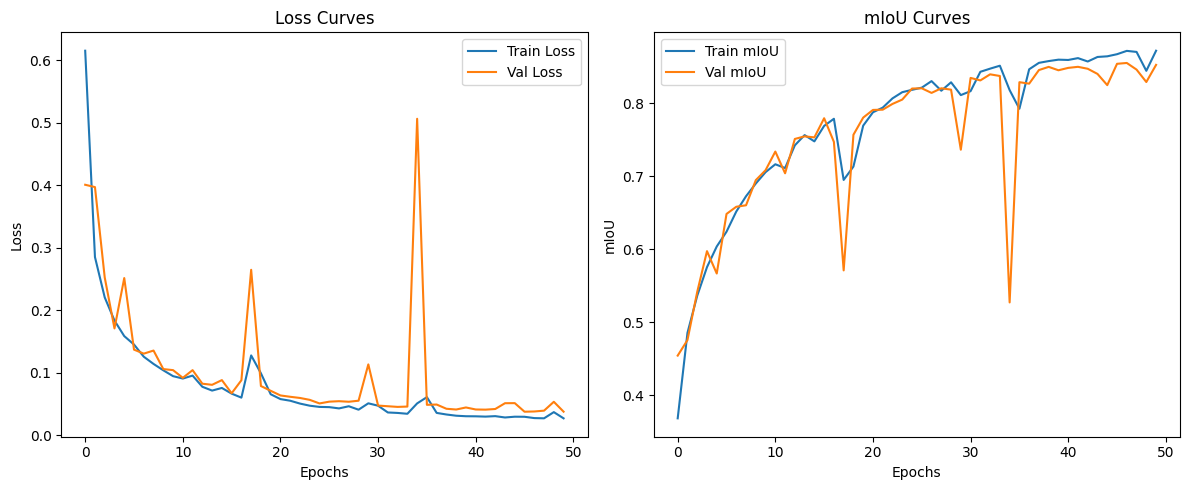

In [3]:

# Check if directories exist
print(f"Train images directory exists: {os.path.exists(train_images_path)}")
print(f"Train labels directory exists: {os.path.exists(train_labels_path)}")
print(f"Test images directory exists: {os.path.exists(test_images_path)}")
print(f"Test labels directory exists: {os.path.exists(test_labels_path)}")

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Try to import albumentations if available, otherwise use basic transformations
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    
    train_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    val_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    # Create datasets with transforms
    train_dataset = SegmentationDataset(train_images_path, train_labels_path, transform=train_transform)
    
    # Split training data into train and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    test_dataset = SegmentationDataset(test_images_path, test_labels_path, transform=val_transform)
    
    print(f"Using albumentations library for transformations")
    
except ImportError:
    print("Albumentations not available, using basic transformations")
    
    # Basic dataset class without albumentations
    class BasicSegmentationDataset(Dataset):
        def __init__(self, images_dir, masks_dir):
            self.images_dir = images_dir
            self.masks_dir = masks_dir
            self.images = sorted(os.listdir(images_dir))
            
        def __len__(self):
            return len(self.images)
        
        def __getitem__(self, idx):
            img_name = self.images[idx]
            img_path = os.path.join(self.images_dir, img_name)
            mask_path = os.path.join(self.masks_dir, img_name)
            
            # Load image and mask
            image = np.array(Image.open(img_path).convert("RGB"))
            mask = np.array(Image.open(mask_path))
            
            # Extract class IDs from mask
            if len(mask.shape) > 2:
                mask = mask[:, :, 0]  # Take first channel if multiple channels
            
            # Basic transformation
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.0
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask).long()  # Explicitly convert to Long type
            
            return image, mask
    
    # Create datasets without special transforms
    train_dataset = BasicSegmentationDataset(train_images_path, train_labels_path)
    
    # Split training data into train and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    test_dataset = BasicSegmentationDataset(test_images_path, test_labels_path)

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create data loaders with proper batch size for Kaggle GPUs
# Reducing batch size for Kaggle's limited VRAM
batch_size = 8  # Lower batch size to avoid CUDA out of memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize the model
model = UNet(n_channels=3, n_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model)}")

# Train the model
print("Starting model training...")
train_losses, val_losses, train_mious, val_mious = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50, 
    device=device
)


In [4]:

# Load best model for testing
print("Loading best model for testing...")
model.load_state_dict(torch.load('/kaggle/working/best_unet_model.pth'))

# Test the model
print("Testing model on test dataset...")
test_miou = test_model(model, test_loader, device)
print(f"Final Test mIoU: {test_miou:.4f}")

<ipython-input-4-69f67bd5601e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_unet_model.pth'))


Loading best model for testing...
Testing model on test dataset...


Testing: 100%|██████████| 63/63 [00:08<00:00,  7.80it/s]

Test mIoU: 0.8335
Final Test mIoU: 0.8335


<ipython-input-5-5af43381a8a8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_unet_model.pth'))


Loading best model for testing...
Testing model on test dataset...


Testing: 100%|██████████| 63/63 [00:08<00:00,  7.59it/s]


Test mIoU: 0.8335
Final Test mIoU: 0.8335

Checking for visualization files...
Found visualization 0


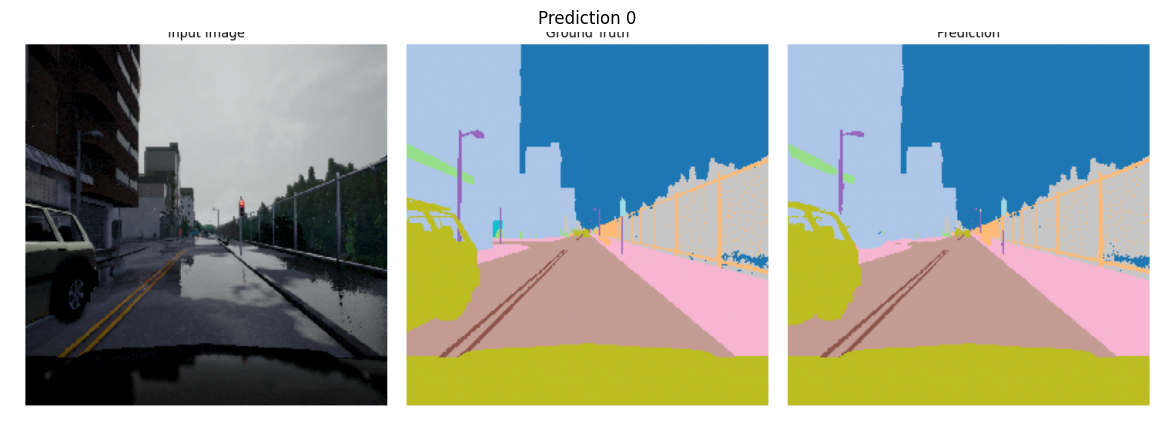

Found visualization 1


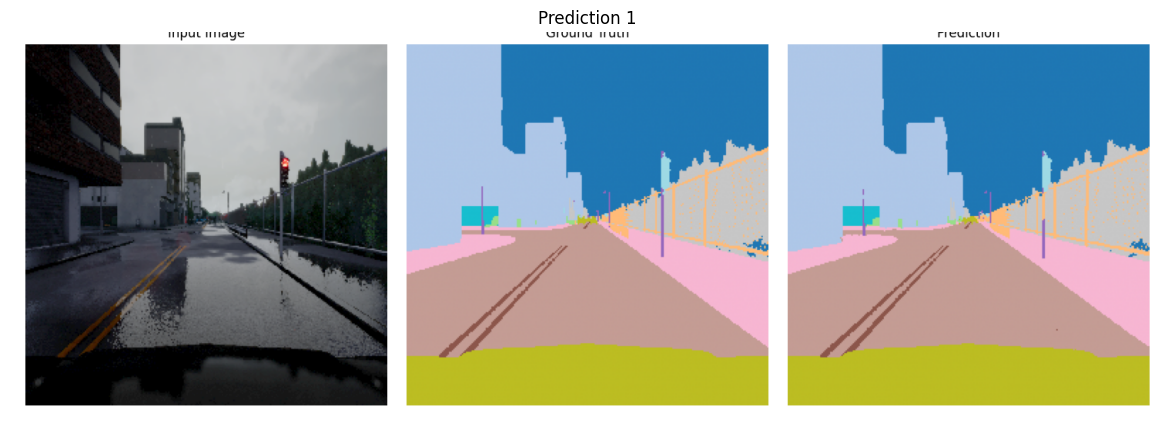

Found visualization 2


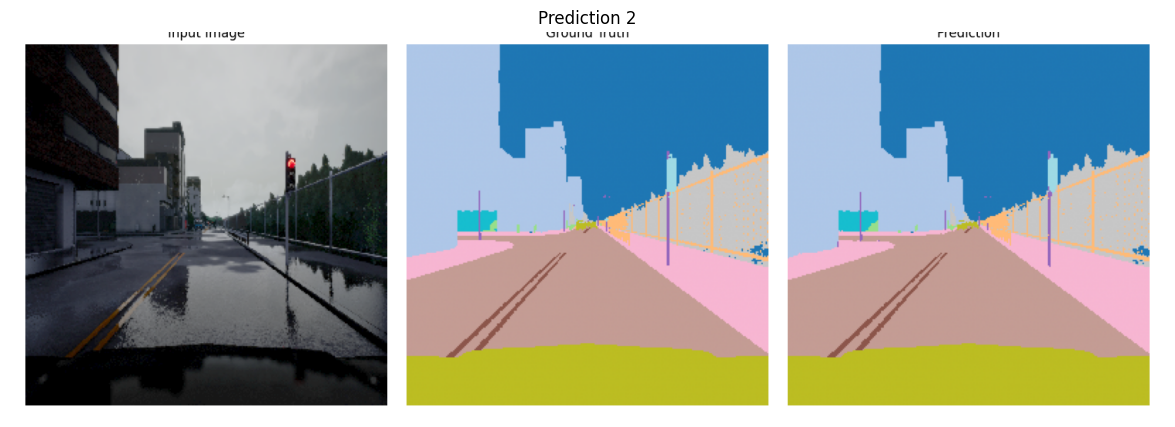

Found visualization 3


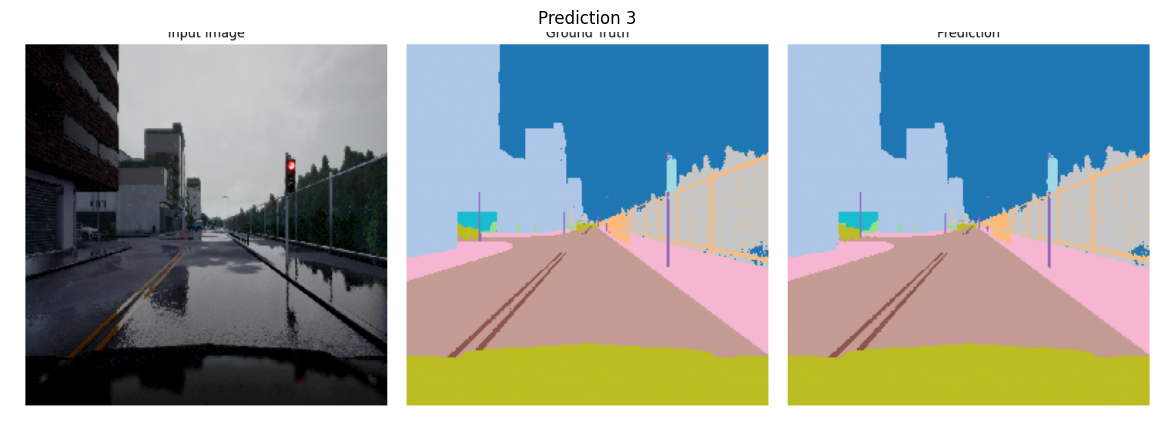

Found visualization 4


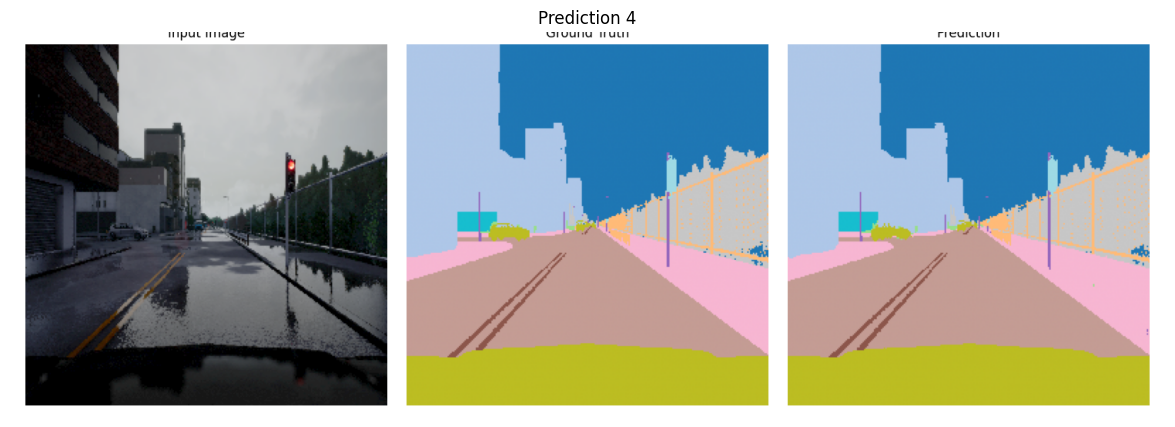


SUMMARY OF RESULTS


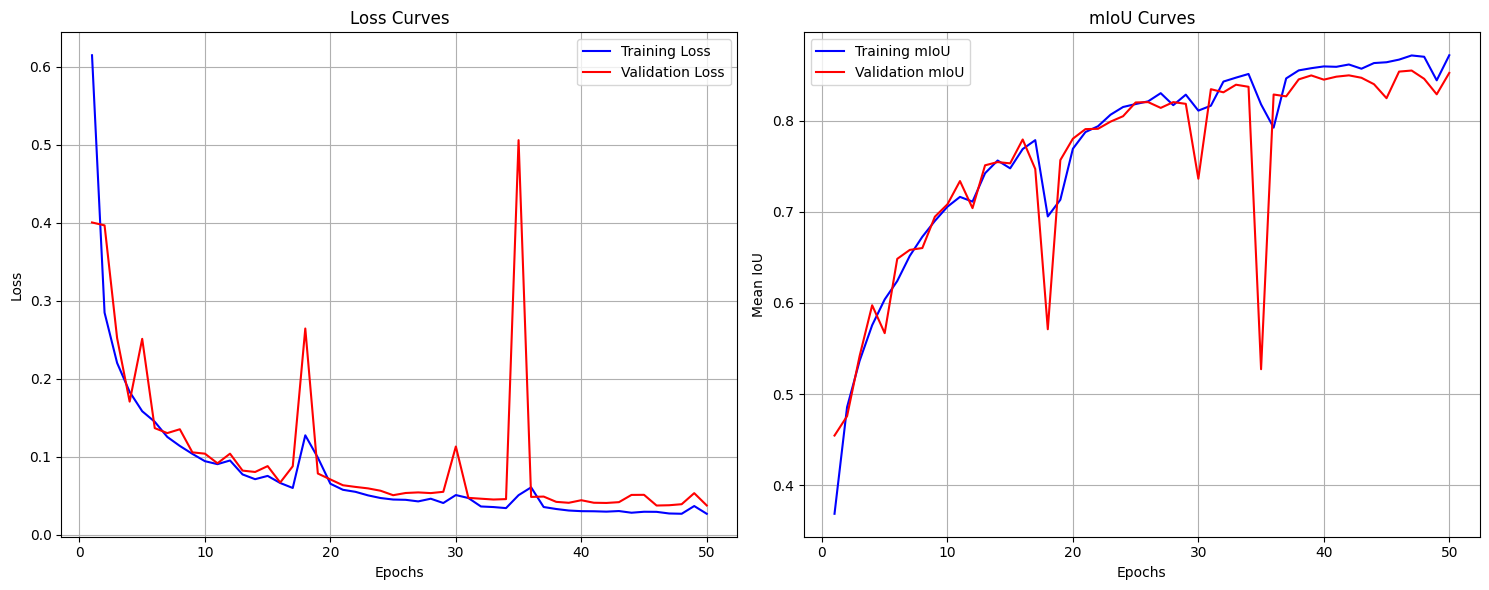

Best Training mIoU: 0.8720
Best Validation mIoU: 0.8552
Final Test mIoU: 0.8335

U-Net Model Training and Evaluation Complete!


In [5]:
# Load best model for testing
print("Loading best model for testing...")
model.load_state_dict(torch.load('/kaggle/working/best_unet_model.pth'))

# Test the model with debug info
print("Testing model on test dataset...")
test_miou = test_model(model, test_loader, device)
print(f"Final Test mIoU: {test_miou:.4f}")

# Check if visualization files exist and display them
print("\nChecking for visualization files...")
for i in range(5):
    vis_path = f'/kaggle/working/prediction_{i}.png'
    if os.path.exists(vis_path):
        print(f"Found visualization {i}")
        # Display the saved visualization
        plt.figure(figsize=(15, 5))
        plt.imshow(plt.imread(vis_path))
        plt.axis('off')
        plt.title(f'Prediction {i}')
        plt.show()
    else:
        print(f"Visualization file {i} not found")

# Additional code for summary display
print("\n" + "="*50)
print("SUMMARY OF RESULTS")
print("="*50)

# Show final training curves
plt.figure(figsize=(15, 6))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot mIoU curves
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_mious) + 1), train_mious, 'b-', label='Training mIoU')
plt.plot(range(1, len(val_mious) + 1), val_mious, 'r-', label='Validation mIoU')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.title('mIoU Curves')
plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/detailed_training_curves.png')
plt.show()

# Print the best mIoU values
best_train_miou = max(train_mious)
best_val_miou = max(val_mious)
print(f"Best Training mIoU: {best_train_miou:.4f}")
print(f"Best Validation mIoU: {best_val_miou:.4f}")
print(f"Final Test mIoU: {test_miou:.4f}")

print("\nU-Net Model Training and Evaluation Complete!")